In [ ]:
!pip install opendatasets --quiet
import opendatasets as od

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import keras
from keras import layers
from keras.preprocessing import image
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import CSVLogger
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.applications.resnet import ResNet101
from keras.layers.convolutional import Conv2D, MaxPooling2D

In [ ]:
KEY='a47e6c1d4d1f552615865491be5c52d1'
URL = 'https://www.kaggle.com/tawsifurrahman/covid19-radiography-database'
data = od.download_kaggle_dataset(URL, data_dir='./')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ashiishkarhade
Your Kaggle Key: ··········


  0%|          | 0.00/745M [00:00<?, ?B/s]

100%|██████████| 745M/745M [00:18<00:00, 41.7MB/s]


In [ ]:
# Remove unwanted files from directory to another
!mv /content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID.metadata.xlsx /content/
!mv /content/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx /content/
!mv /content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal.metadata.xlsx /content/
!mv /content/covid19-radiography-database/COVID-19_Radiography_Dataset/README.md.txt /content/
!mv /content/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral\ Pneumonia.metadata.xlsx /content/
#shutil.move('/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx', '/content/')

# make necessary folders
os.mkdir('/content/covid19-radiography-database/TEST')
os.mkdir('/content/covid19-radiography-database/TEST/COVID')
os.mkdir('/content/covid19-radiography-database/TEST/Lung_Opacity')
os.mkdir('/content/covid19-radiography-database/TEST/Normal')
os.mkdir('/content/covid19-radiography-database/TEST/Viral Pneumonia')

In [ ]:
### FIRST TURN the DIRECTORIES into TRAIN, TEST, VAL DIRECTORIES
TEST_SIZE = 0.1

test_path = '/content/covid19-radiography-database/TEST'
home_path = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset'
for folder in os.listdir(home_path):
    directory_list = os.listdir(home_path+'/'+folder)
    num = len(directory_list)
    ends = int(TEST_SIZE * num)
    subset = directory_list[ends::-1]
    #print(len(subset))
    for image in subset:
        #print(os.path.join(test_path, os.path.join('/', folder)))
        img_path = home_path + '/' + folder + '/' + image
        dest_path = test_path + '/' + folder
        shutil.move(img_path, dest_path)

os.rename('/content/covid19-radiography-database/COVID-19_Radiography_Dataset', '/content/covid19-radiography-database/TRAIN')

In [ ]:
train_dir = '/content/covid19-radiography-database/TRAIN'
test_dir = '/content/covid19-radiography-database/TEST'

In [ ]:
datagen = ImageDataGenerator(rescale = 1./255,)

In [ ]:
train_dataset = datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    class_mode='categorical',
    shuffle=True
)

Found 19046 images belonging to 4 classes.


In [ ]:
test_dataset = datagen.flow_from_directory(
    test_dir, 
    target_size=(224,224),
    class_mode='categorical',
    shuffle=True
)

Found 2119 images belonging to 4 classes.


In [ ]:
test_dataset.class_indices

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
#print(K)

## Custom CNN Model

In [ ]:
model = Sequential([
                    # BLOCK 1
                    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape = (224, 224, 3)),
                    Conv2D(64, kernel_size=(3,3), activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Dropout(0.25),
                    # BLOCK 2
                    Conv2D(128, kernel_size=(3,3), activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Dropout(0.25),
                    # BLOCK 3
                    Conv2D(128, kernel_size=(3,3), activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Dropout(0.25),
                    # BLOCK 4
                    Conv2D(264, kernel_size=(3,3), activation='relu'),
                    MaxPooling2D(pool_size=(2,2)),
                    Dropout(0.25),
                    # block 5
                    Flatten(),
                    Dense(64, activation='relu'),
                    Dropout(0.5),
                    Dense(4, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 128)       0

In [ ]:
history = model.fit(
    train_dataset, 
    epochs=5,
    validation_data = test_dataset, 
    verbose=2
)

Epoch 1/5
596/596 - 88s - loss: 0.4658 - accuracy: 0.8245 - f1_m: 0.8182 - precision_m: 0.8462 - recall_m: 0.7927 - val_loss: 0.3741 - val_accuracy: 0.8603 - val_f1_m: 0.8592 - val_precision_m: 0.8789 - val_recall_m: 0.8412
Epoch 2/5
596/596 - 87s - loss: 0.4384 - accuracy: 0.8351 - f1_m: 0.8311 - precision_m: 0.8558 - recall_m: 0.8084 - val_loss: 0.3504 - val_accuracy: 0.8674 - val_f1_m: 0.8651 - val_precision_m: 0.8759 - val_recall_m: 0.8549
Epoch 3/5
596/596 - 87s - loss: 0.4097 - accuracy: 0.8429 - f1_m: 0.8401 - precision_m: 0.8623 - recall_m: 0.8198 - val_loss: 0.3581 - val_accuracy: 0.8636 - val_f1_m: 0.8570 - val_precision_m: 0.8683 - val_recall_m: 0.8464
Epoch 4/5
596/596 - 86s - loss: 0.3852 - accuracy: 0.8540 - f1_m: 0.8507 - precision_m: 0.8709 - recall_m: 0.8320 - val_loss: 0.3155 - val_accuracy: 0.8858 - val_f1_m: 0.8822 - val_precision_m: 0.8926 - val_recall_m: 0.8724
Epoch 5/5
596/596 - 87s - loss: 0.3708 - accuracy: 0.8590 - f1_m: 0.8574 - precision_m: 0.8748 - recall_

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test_dataset, verbose=0)
print("loss: {:.2f}, accuracy: {:.2f}, f1_score: {:.2f}, precision: {:.2f}, recall: {:.2f}".format(loss, accuracy, f1_score, precision, recall))

loss: 0.32, accuracy: 0.88, f1_score: 0.88, precision: 0.89, recall: 0.87


dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


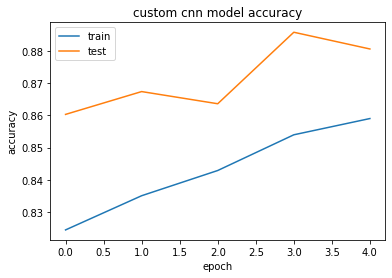

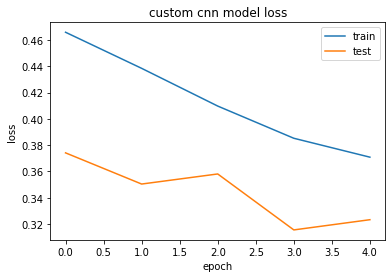

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('custom cnn model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('custom_cnn_accuracy')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('custom cnn model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('custom_cnn_loss')
plt.show()

## VGG19

In [ ]:
from keras.applications.vgg19 import VGG19

In [ ]:
vgg19 = VGG19(weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
x = vgg19.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)


In [ ]:
model = Model(inputs=vgg19.input, outputs=predictions)

In [ ]:
for layer in vgg19.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
history2 = model.fit(
    train_dataset, 
    epochs=5,
    validation_data = test_dataset, 
    verbose=2
)

Epoch 1/5
596/596 - 116s - loss: 0.7779 - accuracy: 0.6885 - f1_m: 0.6522 - precision_m: 0.7557 - recall_m: 0.5803 - val_loss: 0.6526 - val_accuracy: 0.7447 - val_f1_m: 0.7253 - val_precision_m: 0.7829 - val_recall_m: 0.6769
Epoch 2/5
596/596 - 103s - loss: 0.5822 - accuracy: 0.7808 - f1_m: 0.7677 - precision_m: 0.8143 - recall_m: 0.7276 - val_loss: 0.5114 - val_accuracy: 0.8145 - val_f1_m: 0.7984 - val_precision_m: 0.8426 - val_recall_m: 0.7597
Epoch 3/5
596/596 - 103s - loss: 0.5168 - accuracy: 0.8077 - f1_m: 0.8011 - precision_m: 0.8329 - recall_m: 0.7728 - val_loss: 0.4473 - val_accuracy: 0.8339 - val_f1_m: 0.8308 - val_precision_m: 0.8520 - val_recall_m: 0.8113
Epoch 4/5
596/596 - 103s - loss: 0.4885 - accuracy: 0.8161 - f1_m: 0.8102 - precision_m: 0.8376 - recall_m: 0.7854 - val_loss: 0.4320 - val_accuracy: 0.8367 - val_f1_m: 0.8303 - val_precision_m: 0.8585 - val_recall_m: 0.8045
Epoch 5/5
596/596 - 104s - loss: 0.4656 - accuracy: 0.8248 - f1_m: 0.8223 - precision_m: 0.8461 - re

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test_dataset, verbose=0)
print("loss: {:.2f}, accuracy: {:.2f}, f1_score: {:.2f}, precision: {:.2f}, recall: {:.2f}".format(loss, accuracy, f1_score, precision, recall))

loss: 0.43, accuracy: 0.83, f1_score: 0.83, precision: 0.85, recall: 0.81


dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


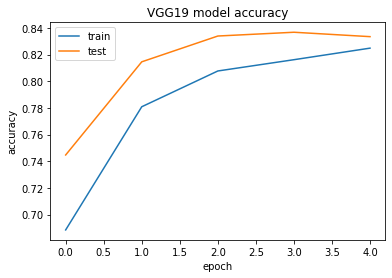

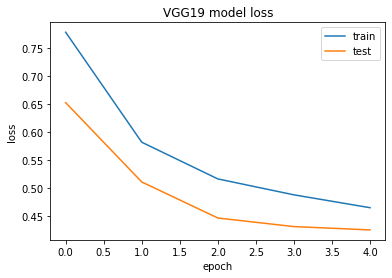

In [ ]:
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('VGG19 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('vgg19_accuracy')
plt.show()

# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('VGG19 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('vgg19_loss')
plt.show()

## InceptionV3

In [ ]:
from keras.applications.inception_v3 import InceptionV3

In [ ]:
inceptionv3 = InceptionV3(include_top=False, weights='imagenet')

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
inceptionv3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
x = inceptionv3.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

In [ ]:
model = Model(inputs=inceptionv3.input, outputs=predictions)

ValueError: ignored

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [ ]:
for layer in inceptionv3.layers:
    layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
history3 = model.fit(
    train_dataset, 
    epochs=5,
    validation_data = test_dataset, 
    verbose=2
)

Epoch 1/5
596/596 - 72s - loss: 0.6508 - accuracy: 0.7577 - f1_m: 0.7493 - precision_m: 0.7889 - recall_m: 0.7151 - val_loss: 0.4946 - val_accuracy: 0.8112 - val_f1_m: 0.8067 - val_precision_m: 0.8454 - val_recall_m: 0.7723
Epoch 2/5
596/596 - 64s - loss: 0.5172 - accuracy: 0.7996 - f1_m: 0.7945 - precision_m: 0.8249 - recall_m: 0.7675 - val_loss: 0.4540 - val_accuracy: 0.8226 - val_f1_m: 0.8215 - val_precision_m: 0.8469 - val_recall_m: 0.7982
Epoch 3/5
596/596 - 63s - loss: 0.4781 - accuracy: 0.8153 - f1_m: 0.8112 - precision_m: 0.8383 - recall_m: 0.7867 - val_loss: 0.4355 - val_accuracy: 0.8372 - val_f1_m: 0.8379 - val_precision_m: 0.8618 - val_recall_m: 0.8160
Epoch 4/5
596/596 - 63s - loss: 0.4525 - accuracy: 0.8282 - f1_m: 0.8241 - precision_m: 0.8486 - recall_m: 0.8018 - val_loss: 0.4310 - val_accuracy: 0.8339 - val_f1_m: 0.8320 - val_precision_m: 0.8574 - val_recall_m: 0.8087
Epoch 5/5
596/596 - 63s - loss: 0.4382 - accuracy: 0.8312 - f1_m: 0.8291 - precision_m: 0.8530 - recall_

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test_dataset, verbose=0)
print("loss: {:.2f}, accuracy: {:.2f}, f1_score: {:.2f}, precision: {:.2f}, recall: {:.2f}".format(loss, accuracy, f1_score, precision, recall))

loss: 0.41, accuracy: 0.85, f1_score: 0.85, precision: 0.87, recall: 0.84


dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


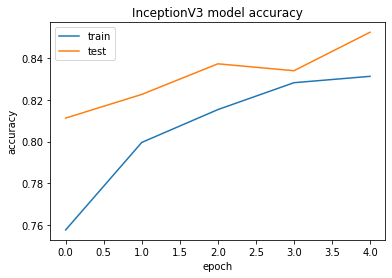

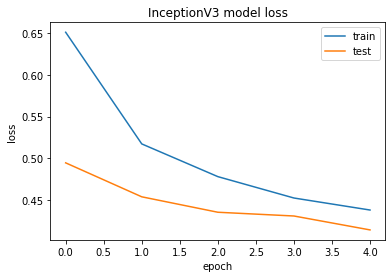

In [ ]:
print(history3.history.keys())
# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('InceptionV3 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('inceptionv3_accuracy')
plt.show()

# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('InceptionV3 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('inceptionv3_loss')
plt.show()

## InceptionResNetV2

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [ ]:
inception_resnet = InceptionResNetV2(include_top=False, weights='imagenet')

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
inception_resnet.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_99[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
________________________________________________________________________________

In [ ]:
x = inception_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

In [ ]:
model = Model(inputs=inception_resnet.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, None, None, 3 96          conv2d_99[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, None, None, 3 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [ ]:
for layer in inception_resnet.layers:
    layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
history4 = model.fit(
    train_dataset, 
    epochs=5,
    validation_data = test_dataset, 
    verbose=2
)

Epoch 1/5
596/596 - 132s - loss: 0.6639 - accuracy: 0.7504 - f1_m: 0.7399 - precision_m: 0.7830 - recall_m: 0.7027 - val_loss: 0.5412 - val_accuracy: 0.8023 - val_f1_m: 0.7887 - val_precision_m: 0.8373 - val_recall_m: 0.7467
Epoch 2/5
596/596 - 118s - loss: 0.5256 - accuracy: 0.7995 - f1_m: 0.7941 - precision_m: 0.8270 - recall_m: 0.7648 - val_loss: 0.5641 - val_accuracy: 0.7744 - val_f1_m: 0.7710 - val_precision_m: 0.8038 - val_recall_m: 0.7420
Epoch 3/5
596/596 - 118s - loss: 0.4913 - accuracy: 0.8123 - f1_m: 0.8089 - precision_m: 0.8363 - recall_m: 0.7840 - val_loss: 0.4673 - val_accuracy: 0.8202 - val_f1_m: 0.8152 - val_precision_m: 0.8407 - val_recall_m: 0.7921
Epoch 4/5
596/596 - 118s - loss: 0.4731 - accuracy: 0.8207 - f1_m: 0.8177 - precision_m: 0.8433 - recall_m: 0.7944 - val_loss: 0.4499 - val_accuracy: 0.8249 - val_f1_m: 0.8191 - val_precision_m: 0.8491 - val_recall_m: 0.7920
Epoch 5/5
596/596 - 118s - loss: 0.4472 - accuracy: 0.8321 - f1_m: 0.8283 - precision_m: 0.8515 - re

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test_dataset, verbose=0)
print("loss: {:.2f}, accuracy: {:.2f}, f1_score: {:.2f}, precision: {:.2f}, recall: {:.2f}".format(loss, accuracy, f1_score, precision, recall))

loss: 0.43, accuracy: 0.84, f1_score: 0.84, precision: 0.86, recall: 0.82


dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


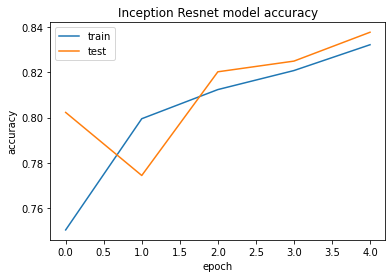

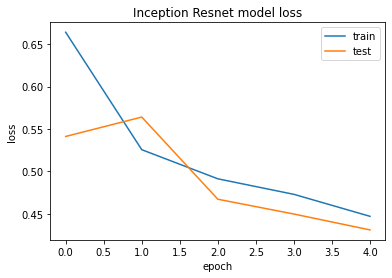

In [ ]:
print(history4.history.keys())
# summarize history for accuracy
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Inception Resnet model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Inception-resnet_accuracy')
plt.show()

# summarize history for loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Inception Resnet model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('inception-resnet_loss')
plt.show()

## ResNet152V2

In [ ]:
from keras.applications.resnet_v2 import ResNet152V2

In [ ]:
resnet152 = ResNet152V2(include_top=False, weights='imagenet')

234553344/234545216 [==============================] - 5s 0us/step


In [ ]:
resnet152.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [ ]:
x = resnet152.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

In [ ]:
model = Model(inputs=resnet152.input, outputs=predictions)

In [ ]:
for layer in resnet152.layers:
    layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
history5 = model.fit(
    train_dataset, 
    epochs=5,
    validation_data = test_dataset, 
    verbose=2
)

Epoch 1/5
596/596 - 359s - loss: 0.5154 - accuracy: 0.8093 - f1_m: 0.8065 - precision_m: 0.8311 - recall_m: 0.7843 - val_loss: 0.3913 - val_accuracy: 0.8546 - val_f1_m: 0.8550 - val_precision_m: 0.8705 - val_recall_m: 0.8405
Epoch 2/5
596/596 - 313s - loss: 0.3741 - accuracy: 0.8592 - f1_m: 0.8578 - precision_m: 0.8725 - recall_m: 0.8440 - val_loss: 0.3170 - val_accuracy: 0.8924 - val_f1_m: 0.8903 - val_precision_m: 0.9038 - val_recall_m: 0.8777
Epoch 3/5
596/596 - 313s - loss: 0.3342 - accuracy: 0.8745 - f1_m: 0.8740 - precision_m: 0.8847 - recall_m: 0.8639 - val_loss: 0.3366 - val_accuracy: 0.8749 - val_f1_m: 0.8769 - val_precision_m: 0.8828 - val_recall_m: 0.8713
Epoch 4/5
596/596 - 313s - loss: 0.3050 - accuracy: 0.8851 - f1_m: 0.8848 - precision_m: 0.8943 - recall_m: 0.8759 - val_loss: 0.3029 - val_accuracy: 0.8924 - val_f1_m: 0.8905 - val_precision_m: 0.8995 - val_recall_m: 0.8819
Epoch 5/5
596/596 - 312s - loss: 0.2800 - accuracy: 0.8950 - f1_m: 0.8945 - precision_m: 0.9021 - re

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test_dataset, verbose=0)
print("loss: {:.2f}, accuracy: {:.2f}, f1_score: {:.2f}, precision: {:.2f}, recall: {:.2f}".format(loss, accuracy, f1_score, precision, recall))

loss: 0.30, accuracy: 0.89, f1_score: 0.89, precision: 0.90, recall: 0.89


In [ ]:
model.save('resnet152v2e5v1.h5')

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


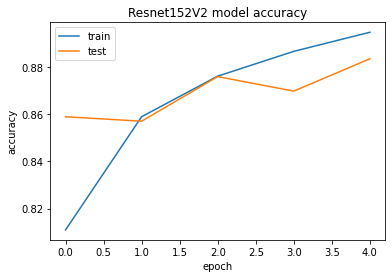

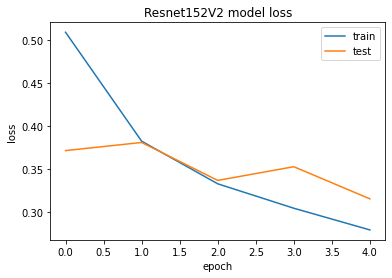

In [ ]:
print(history5.history.keys())
# summarize history for accuracy
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Resnet152V2 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('resnet152_accuracy')
plt.show()

# summarize history for loss
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Resnet152V2 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('resnet152_loss')
plt.show()

## Xception Net

In [ ]:
from keras.applications.xception import Xception

In [ ]:
xcept = Xception(include_top=False, weights='imagenet')

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
xcept.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
x = xcept.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

In [ ]:
model = Model(inputs=xcept.input, outputs=predictions)

In [ ]:
for layer in xcept.layers:
    layer.trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
history6 = model.fit(
    train_dataset, 
    epochs=5,
    validation_data = test_dataset, 
    verbose=2
)

Epoch 1/5
596/596 - 94s - loss: 0.5768 - accuracy: 0.7755 - f1_m: 0.7706 - precision_m: 0.8092 - recall_m: 0.7379 - val_loss: 0.4972 - val_accuracy: 0.8013 - val_f1_m: 0.7969 - val_precision_m: 0.8281 - val_recall_m: 0.7689
Epoch 2/5
596/596 - 89s - loss: 0.4613 - accuracy: 0.8266 - f1_m: 0.8229 - precision_m: 0.8475 - recall_m: 0.8005 - val_loss: 0.4453 - val_accuracy: 0.8311 - val_f1_m: 0.8299 - val_precision_m: 0.8588 - val_recall_m: 0.8038
Epoch 3/5
596/596 - 88s - loss: 0.4176 - accuracy: 0.8434 - f1_m: 0.8410 - precision_m: 0.8602 - recall_m: 0.8232 - val_loss: 0.4239 - val_accuracy: 0.8358 - val_f1_m: 0.8329 - val_precision_m: 0.8504 - val_recall_m: 0.8166
Epoch 4/5
596/596 - 88s - loss: 0.3930 - accuracy: 0.8521 - f1_m: 0.8518 - precision_m: 0.8681 - recall_m: 0.8367 - val_loss: 0.4232 - val_accuracy: 0.8362 - val_f1_m: 0.8380 - val_precision_m: 0.8517 - val_recall_m: 0.8251
Epoch 5/5
596/596 - 88s - loss: 0.3699 - accuracy: 0.8611 - f1_m: 0.8600 - precision_m: 0.8756 - recall_

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test_dataset, verbose=0)
print("loss: {:.2f}, accuracy: {:.2f}, f1_score: {:.2f}, precision: {:.2f}, recall: {:.2f}".format(loss, accuracy, f1_score, precision, recall))

loss: 0.40, accuracy: 0.85, f1_score: 0.85, precision: 0.86, recall: 0.83


dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


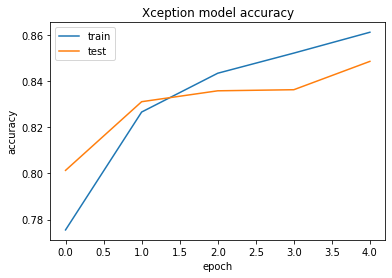

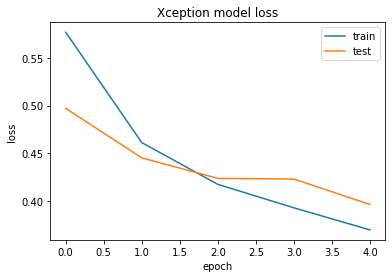

In [ ]:
print(history6.history.keys())
# summarize history for accuracy
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('Xception model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('xception_accuracy')
plt.show()

# summarize history for loss
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Xception model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('xception_loss')
plt.show()

# Comparison of all models

In [ ]:
# F1 SCORES
cnn_f1 = [0.8592, 0.8651, 0.8570, 0.8822, 0.8825]
vgg19_f1 = [0.7253, 0.7984, 0.8308, 0.8303, 0.8366]
inceptionv3_f1 = [0.8067, 0.8215, 0.8379, 0.8320, 0.8540]
inc_resnet_f1 = [0.7399, 0.7941, 0.8089, 0.8177, 0.8283]
resnet_f1 = [0.8532, 0.8535, 0.8764, 0.8719, 0.8812]
xception_f1 = [0.7969, 0.8299, 0.8329, 0.8380, 0.8460]

In [ ]:
# Validation Accuracy
cnn_acc = [0.8603, 0.8674, 0.8636, 0.8858, 0.8806]
vgg19_acc = [0.7447, 0.8145, 0.8339, 0.8367, 0.8334]
inceptionv3_acc = [0.8112, 0.8226, 0.8372, 0.8339, 0.8523]
inc_resnet_acc = [0.7504, 0.7995, 0.8123, 0.8207, 0.8321]
resnet_acc = [0.8589, 0.8570, 0.8759, 0.8697, 0.8834]
xception_acc = [0.8013, 0.8311, 0.8358, 0.8362, 0.8485]

In [ ]:
import pandas as pd
cols = ['CNN', 'VGG19', 'InceptionV3', 'Inception-Resnet', 'Resnet152', 'Xception']
idxs = ['Epoch:1','Epoch:2','Epoch:3','Epoch:4','Epoch:5']

In [ ]:
f1_scores = pd.DataFrame(zip(cnn_f1, vgg19_f1, inceptionv3_f1, inc_resnet_f1, resnet_f1, xception_f1), columns=cols, index=idxs)
f1_scores

,CNN,VGG19,InceptionV3,Inception-Resnet,Resnet152,Xception
Epoch:1,0.8592,0.7253,0.8067,0.7399,0.8532,0.7969
Epoch:2,0.8651,0.7984,0.8215,0.7941,0.8535,0.8299
Epoch:3,0.8570,0.8308,0.8379,0.8089,0.8764,0.8329
Epoch:4,0.8822,0.8303,0.8320,0.8177,0.8719,0.8380
Epoch:5,0.8825,0.8366,0.8540,0.8283,0.8812,0.8460


In [ ]:
val_scores = pd.DataFrame(zip(cnn_acc, vgg19_acc, inceptionv3_acc, inc_resnet_acc, resnet_acc, xception_acc), columns=cols, index=idxs)
val_scores

,CNN,VGG19,InceptionV3,Inception-Resnet,Resnet152,Xception
Epoch:1,0.8603,0.7447,0.8112,0.7504,0.8589,0.8013
Epoch:2,0.8674,0.8145,0.8226,0.7995,0.8570,0.8311
Epoch:3,0.8636,0.8339,0.8372,0.8123,0.8759,0.8358
Epoch:4,0.8858,0.8367,0.8339,0.8207,0.8697,0.8362
Epoch:5,0.8806,0.8334,0.8523,0.8321,0.8834,0.8485


As we can see, ResNet152V2 performs very well than other models for our problem. We will be selecting Resnet152V2 as our final model